# BERT base neuralmind, soma dos score do par.

## ontoPT-validation
- (1,1) é um par onde hipônimo e hiperônimo são de tamanho 1
- O tamanho do par (1,1) será 2, assim como o tamanho do par (2,1) e (1,2) será 3

> Suponha o par (3,2) (abacate, fruta)
> Temos as seguintes sentenças:
- [MASK] ca te é um tipo de fru ta
- aba [MASK] te é um tipo de fru ta
- aba ca [MASK] é um tipo de fru ta
- aba ca te é um tipo de [MASK] ta
- aba ca te é um tipo de fru [MASK]

> Mascarando a palavra e pegando o score dela. O score pra esse par será a soma de todos os valores recuperados.

## Usando wikipedia240M para comparação
 - Sem OOV = 42800 pares
 - com OOV = 94446 pares
 
 



In [61]:
import sys
sys.path.append("/home/gabrielescobar/hyper_bert")
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import nb_utils
import os

sns.set(style="whitegrid")

vocabs = ["../../vocabs/wikipedia15M/vocab.txt",
          "../../vocabs/wikipedia30M/vocab.txt",
          "../../vocabs/wikipedia60M/vocab.txt",
          "../../vocabs/wikipedia120M/vocab.txt",
          "../../vocabs/wikipedia240M/vocab.txt"]
# data
#server
path_file_bert = "/home/gabrielescobar/hyper_bert/teste/neuralmind-bert-base-portuguese-cased_bert-score_n-subtoken/ontoPT-validation.json"
json_data = json.load(open(path_file_bert))
df_240 = nb_utils.create_dataframe(nb_utils.filter_by_vocab(vocabs[4], json_data), separator=" ")
df_with_oov = nb_utils.create_dataframe(json_data, separator=" ")
pattern_unique = df_with_oov['pattern'].unique().tolist()
len_total_unique = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]


print(f"DF 240 = {df_240[df_240['pattern'] == pattern_unique[0]].count()['hiponimo']}")
print(f"DF all with OOV = {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]].count()['hiponimo']}")

# df com oov
df_with_oov = nb_utils.logsumexp_normalization(df_with_oov, len_list=len_total_unique, pattern_list=pattern_unique)

# df 240M sem oov
df_240 = nb_utils.logsumexp_normalization(df_240, len_list=len_total_unique, pattern_list=pattern_unique)

DF 240 = 42800
DF all with OOV = 94446


## Balanceamento do Dataset e AP por padrão
#### Wikipedia 240M sem OOV
 - N = 42800 pares


#### Gŕaficos do BERT log_sum_exp log(Z) no DEV português

 - % de pares verdadeiros por tamanho de sub-token
 - AP por padrão (português) no DEV
 - AP combinando os N melhores padrões (Average rank e Min rank)
 - Balanceamento do DEV sem oov 54.28% True, 45.71% False

In [62]:
# metodo para modificar o bert-logZ e penalizar aqueles pares de comprimento maior
# df.update(df.loc[df['len_total'] == 11, 'score_final_log(z)'].apply(lambda x: x * 1.5))
scalar = 2.0
for i in range(6, 19):
    df_240.update(df_240.loc[df_240['len_total'] == i, 'score_final_log(z)'].apply(lambda x: x * scalar))
    scalar = scalar * 1.5

Balanceamento: [1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!


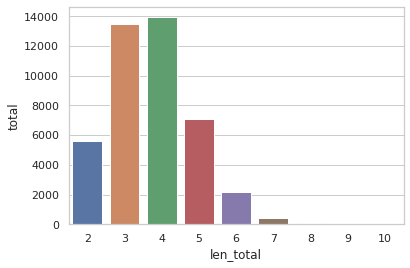

In [26]:
# Balanceamento df_with_oov
df_240_ratio = nb_utils.balanceamento(df_240, patterns=pattern_unique,len_size=len_total_unique)
df_240_ratio['total'] = df_240_ratio['true'] + df_240_ratio['false']
ax = sns.barplot(x="len_total", y="total", data=df_240_ratio)

Balanceamento: [1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!


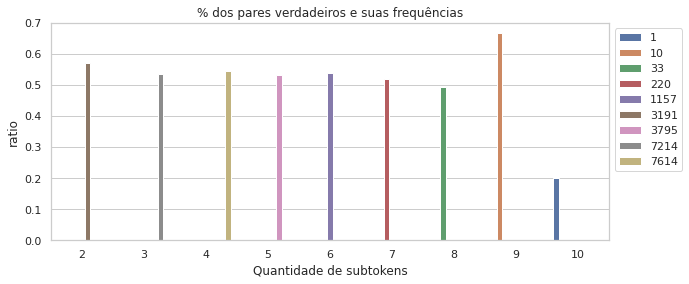

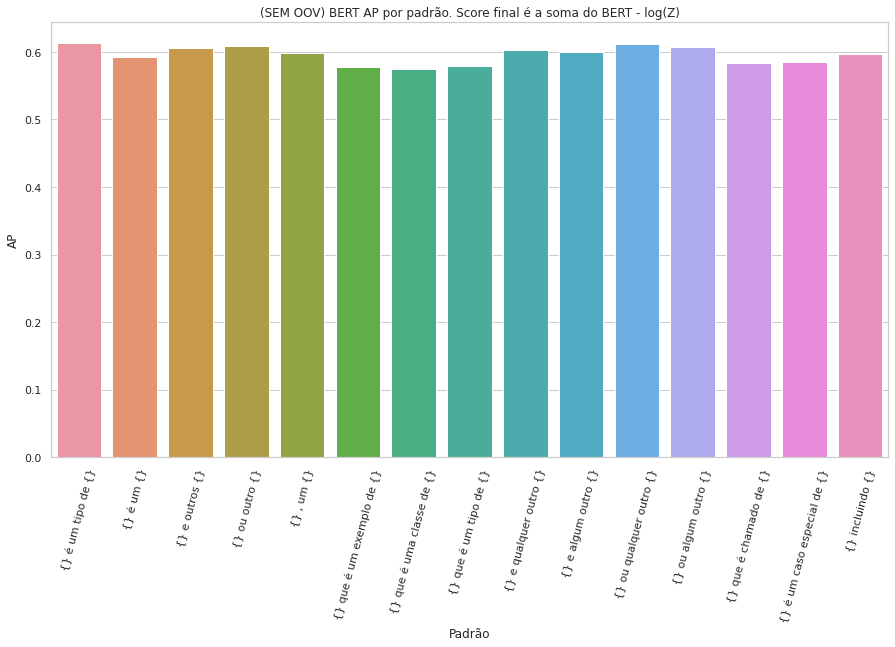

Melhores padrões usando score_final_log(Z)
['{} é um tipo de {}', '{} ou qualquer outro {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']


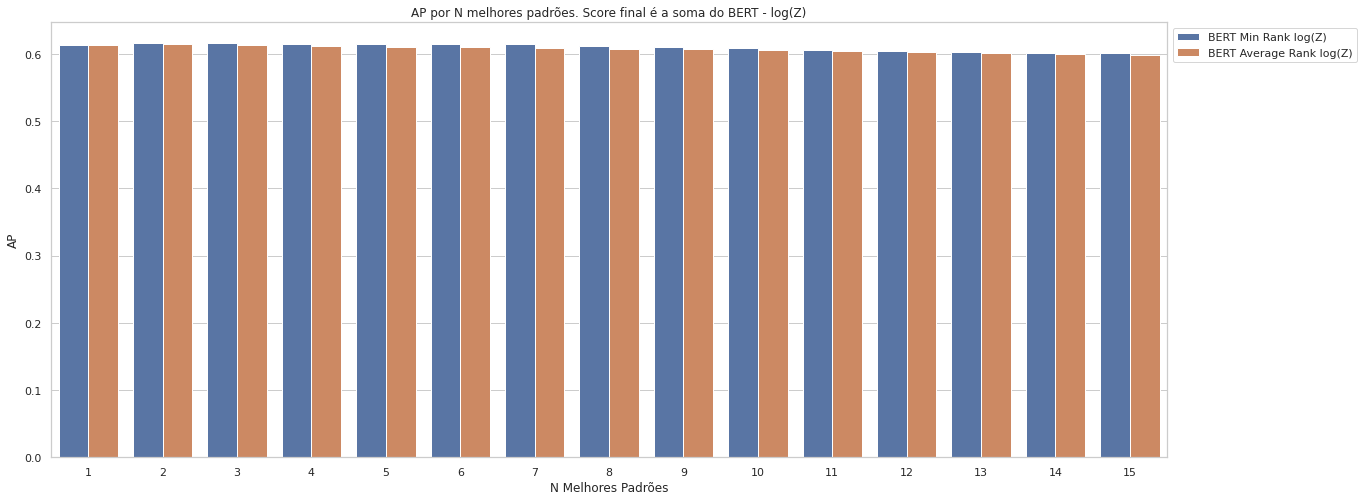

In [63]:
# Balanceamento df_240M
df_240_ratio = nb_utils.balanceamento(df_240, len_size=len_total_unique, patterns=pattern_unique)

plt.figure(figsize=(10, 4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_240_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")
ax.legend(bbox_to_anchor=(1, 1))

# AP por padrão
df_plot = nb_utils.compute_dataframe_AP_by_pattern(df_240, key_sort="score_final_log(z)", pattern_list=pattern_unique)
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"(SEM OOV) BERT AP por padrão. Score final é a soma do BERT - log(Z)")
plt.xticks(rotation=75)
plt.show()

print(f"Melhores padrões usando score_final_log(Z)")
best_pattern_logz = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_logz)


# AP por n-rank
df_plot = nb_utils.compute_AP_n_best_pattern(df_240, key_sort="score_final_log(z)", n_best_pattern=best_pattern_logz)
df_plot['method_format'] = df_plot['method'].map(nb_utils.get_method_name_ijcai())
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method_format')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"AP por N melhores padrões. Score final é a soma do BERT - log(Z)")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Dados dos gráficos acima. Apenas para visualizar mesmo!

 - mean score_final_log(z) == Average Rank usando BERT - log_sum_exp log(Z)
 - min score_final_log(z)  == Min Rank usando BERT - log_sum_exp log(Z)
 - Balanceamento do DEV 54.28% True, 45.71% False
 - Total de 42800 pares

In [64]:
df_mean = df_plot[df_plot['method'] == 'mean score_final_log(z)']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"Melhor combinação de Melhores Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min score_final_log(z)']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

# balanceamento do dataset inteiro
df_size = nb_utils.balanceamento_all(df_240, patterns=pattern_unique)
print(df_size)

Melhor combinação de Melhores Padrões usando Média dos ranks entre eles
   n_best_pattern                   method        AP             method_format
3               2  mean score_final_log(z)  0.614397  BERT Average Rank log(Z)
5               3  mean score_final_log(z)  0.612874  BERT Average Rank log(Z)
1               1  mean score_final_log(z)  0.612774  BERT Average Rank log(Z)
7               4  mean score_final_log(z)  0.611712  BERT Average Rank log(Z)
Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles
   n_best_pattern                  method        AP         method_format
4               3  min score_final_log(z)  0.616018  BERT Min Rank log(Z)
2               2  min score_final_log(z)  0.615995  BERT Min Rank log(Z)
6               4  min score_final_log(z)  0.615456  BERT Min Rank log(Z)
8               5  min score_final_log(z)  0.615250  BERT Min Rank log(Z)
           true         false  total
0  23235.000000  19565.000000  42800
1      0.542874 

### DEV Balanceamento do ontoPT-validation com OOV
#### Wikipedia 240M com OOV
 - N = 94446 pares

#### Gŕaficos do BERT log_sum_exp log(Z) no DEV português

 - % de pares verdadeiros por tamanho de sub-token
 - AP por padrão (português) no DEV
 - AP combinando os N melhores padrões (Average rank e Min rank)
 - Balanceamento do DEV 49.86% True, 50.13% False



Balanceamento: [1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] não está no dataframe!


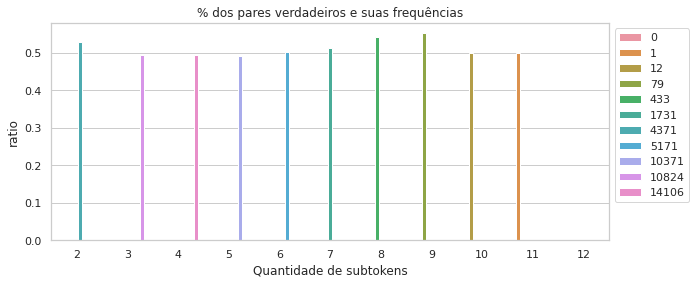

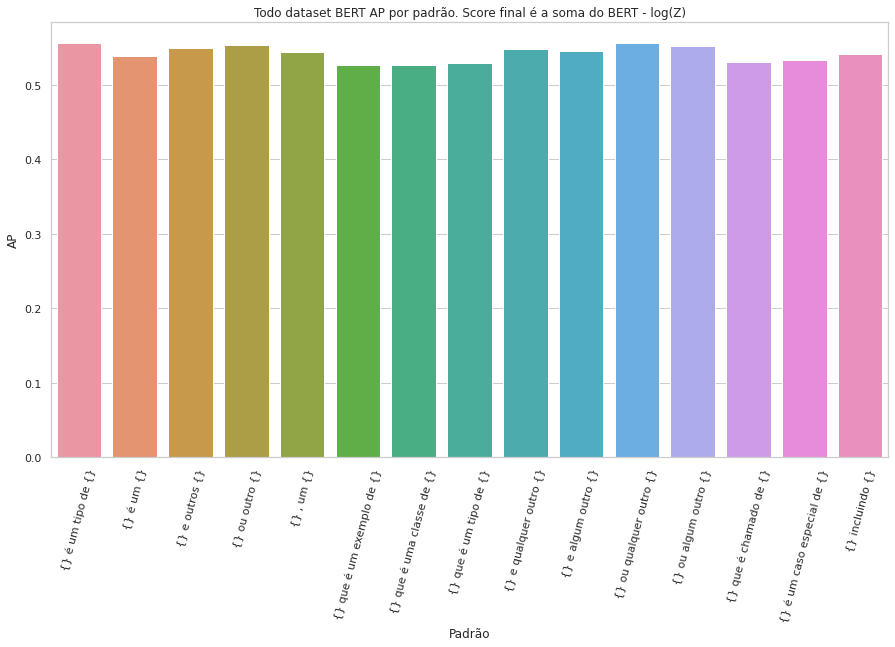

Melhores padrões usando score_final_log(Z)
['{} ou qualquer outro {}', '{} é um tipo de {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']


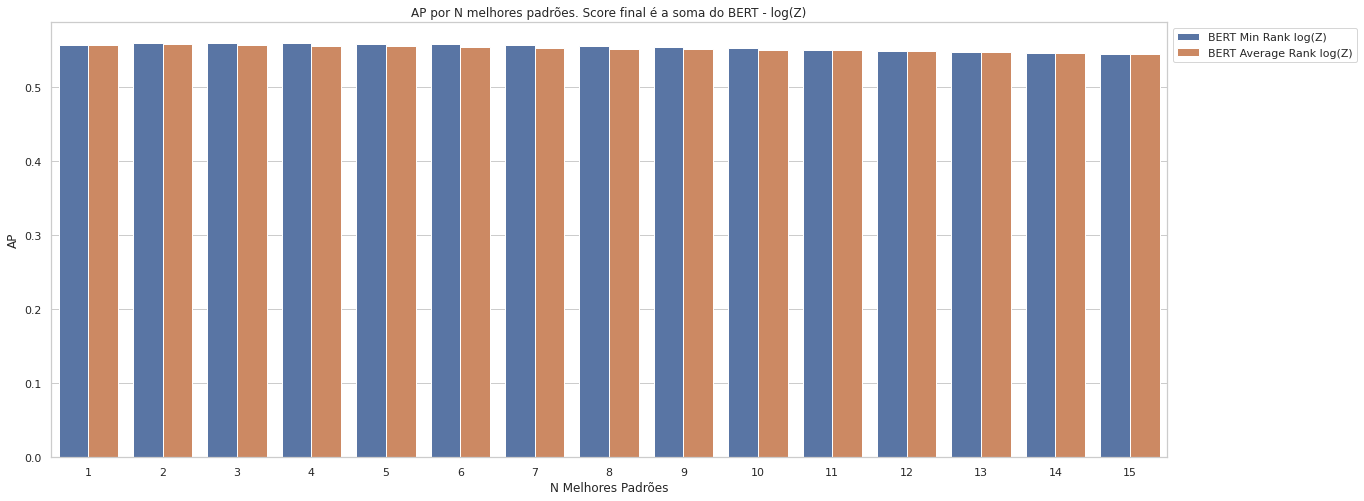

In [29]:
# Balanceamento df_with_oov
df_with_oov_ratio = nb_utils.balanceamento(df_with_oov, len_size=len_total_unique, patterns=pattern_unique)

plt.figure(figsize=(10, 4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_with_oov_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")
ax.legend(bbox_to_anchor=(1, 1))

# AP por padrão
df_plot = nb_utils.compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_log(z)", pattern_list=pattern_unique)
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"Todo dataset BERT AP por padrão. Score final é a soma do BERT - log(Z)")
plt.xticks(rotation=75)
plt.show()

print(f"Melhores padrões usando score_final_log(Z)")
best_pattern_logz = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_logz)


# AP por n-rank
df_plot = nb_utils.compute_AP_n_best_pattern(df_with_oov, key_sort="score_final_log(z)", n_best_pattern=best_pattern_logz)
df_plot['method_format'] = df_plot['method'].map(nb_utils.get_method_name_ijcai())
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method_format')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"AP por N melhores padrões. Score final é a soma do BERT - log(Z)")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()


#### DEV Dados dos gráficos acima. Apenas para visualizar mesmo!
##### DEV usando todo o dataset (COM OOV)
 - mean score_final_log(z) == Average Rank usando BERT - log_sum_exp log(Z)
 - min score_final_log(z)  == Min Rank usando BERT - log_sum_exp log(Z)
 - Balanceamento do DEV 49.86% True, 50.13% False
 - Total de 94446 pares

In [30]:
df_mean = df_plot[df_plot['method'] == 'mean score_final_log(z)']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"Melhor combinação de Melhores Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min score_final_log(z)']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

# balanceamento do dataset inteiro
df_size = nb_utils.balanceamento_all(df_with_oov, patterns=pattern_unique)
print(df_size)

Melhor combinação de Melhores Padrões usando Média dos ranks entre eles
   n_best_pattern                   method        AP             method_format
3               2  mean score_final_log(z)  0.557288  BERT Average Rank log(Z)
5               3  mean score_final_log(z)  0.556178  BERT Average Rank log(Z)
1               1  mean score_final_log(z)  0.555868  BERT Average Rank log(Z)
7               4  mean score_final_log(z)  0.555246  BERT Average Rank log(Z)
Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles
   n_best_pattern                  method        AP         method_format
4               3  min score_final_log(z)  0.558960  BERT Min Rank log(Z)
2               2  min score_final_log(z)  0.558936  BERT Min Rank log(Z)
6               4  min score_final_log(z)  0.558514  BERT Min Rank log(Z)
8               5  min score_final_log(z)  0.558157  BERT Min Rank log(Z)
           true         false  total
0  47099.000000  47347.000000  94446
1      0.498687 